# Housing Prices - Support Vector Regression (SVR)


Using SVR to predict the median house value per neighbourhood and comparing the results to a regular linear regression.

**Note: This is a "training" project to finish exercise 10 on chapter "5: Support Vector Machines" in the book "Hands-on Machine Learning with Scikit-learn, Keras and Tensorflow" by Aurélien Géron.**

<h1 align="center">- $\infty$ -</h1>

**Pre-processing and feature engineering:**
- Impute nan values - DONE
- Remove capped data for age and value - DONE
- Remove some of the highly correlated values (number of rooms) --> does not improve model
- Fix categorical value into one-hot --> DONE with remove_first=True
- Try to even out distribution to normal distribution --> does not improve model as SVR does not assume normal distribution.

**Modelling:**
- Trained SVR with RBF and Linear
- Trained a standard linear regression model to compare results
- Feature engineering
- Tuned hyperparameters of SVR model
- Saved a final SVR model (the optimal model incl. preprocessing) as a pkl file

## Getting the data

In [1]:
# Download the housing dataset
import os
import tarfile # to unzip
import urllib # to request from URL

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# Open the housing dataset
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


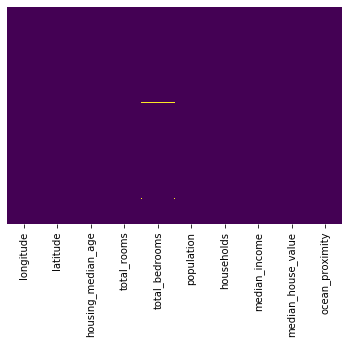

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(housing.isnull(), yticklabels=False, cbar=False, cmap="viridis")

One attibute with null values - total_bedrooms --> will handle this when preprocessing.

In [7]:
housing["ocean_proximity"].value_counts()[:]

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The only categorical attribute in the dataset with 5 values --> will probably combine ISLAND with NEAR BAY and perform onehot encoding.


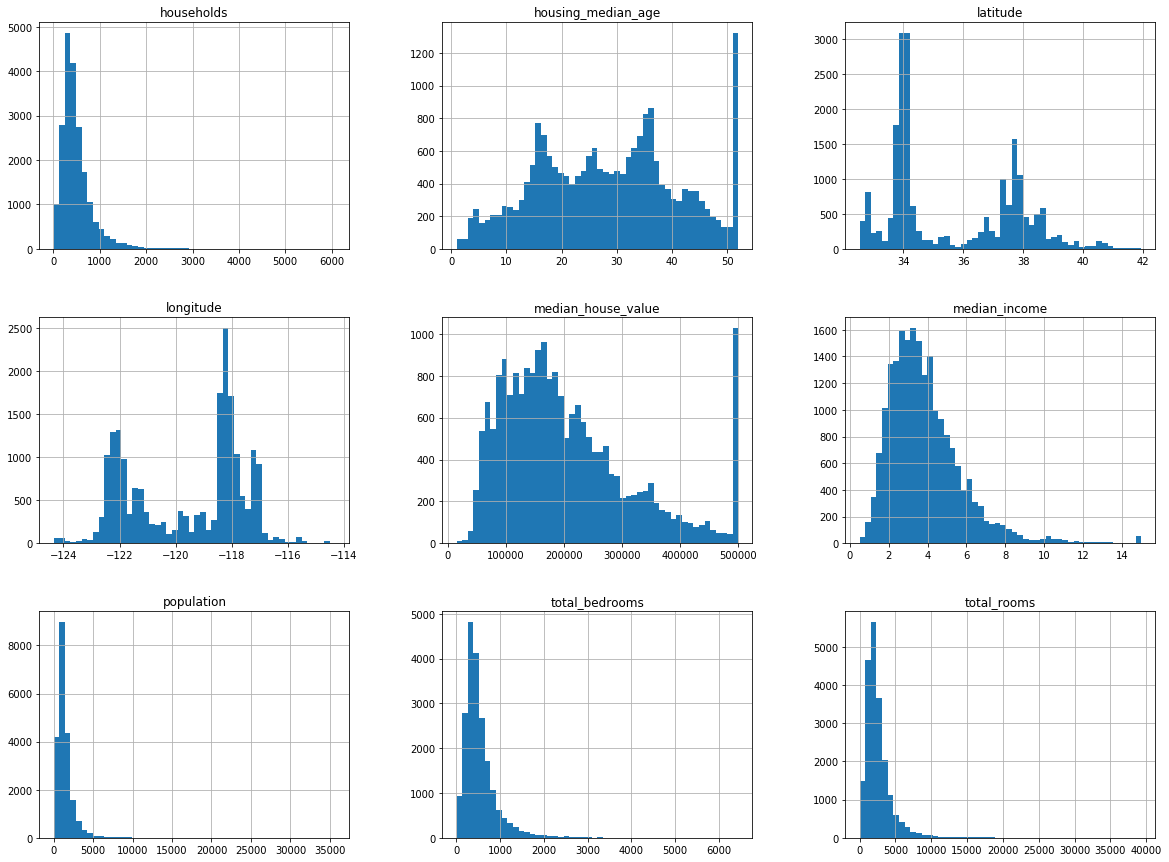

In [8]:
# Plot the distribution for numerical values
housing.hist(bins=50, figsize=(20,15))
plt.show()

- The attributes have different scales --> will standardize the scales.

- Non-normal distributions --> No need to log normalize as SVM does not assume normal distribution.

- Also the attributes housing_median_age and housing_median_value seems capped at the max values --> might remove the instances for max values for a better model prediction.

In [259]:
test = housing.copy()

In [263]:
# noting the value where housing_median_age was cut off
print(test["housing_median_age"].max())
len(test[test["housing_median_age"] == test["housing_median_age"].max()])
truncatation_values = {"housing_median_age": test["housing_median_age"].max()}

52.0


In [265]:
# noting the value where median_house_value was cut off
print(test["median_house_value"].max())
len(test[test["median_house_value"] == test["median_house_value"].max()])
truncatation_values["median_house_value"] = test["median_house_value"].max()

500001.0


In [267]:
# Truncation values for the above two parameters for future use.
truncatation_values

{'housing_median_age': 52.0, 'median_house_value': 500001.0}

**Question: How does the parameter distributions affect a ML model and SVM in particular?**
- **Answer: it does not as SVM does not assume normal distribution.**

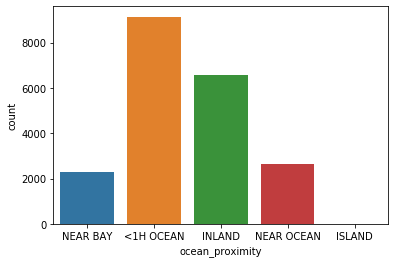

In [9]:
sns.countplot(x=housing["ocean_proximity"])

## Splitting into a train and test set using stratified sampling.

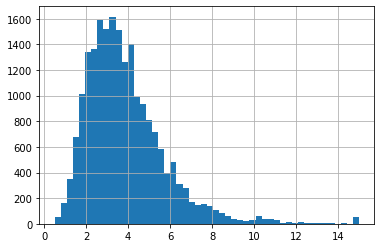

In [10]:
housing["median_income"].hist(bins=50)

In [357]:
# Tagging the dataset with income categories to be able to stratify on this category.
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 2, 4, 6, 8, np.inf],
                               labels=[1, 2, 3, 4, 5]                             
                              )

In [13]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2


In [358]:
# Stratified sampling on income_cat.
from sklearn.model_selection import train_test_split

X = housing.copy().drop("median_house_value", axis=1)
y = housing.copy()["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=housing["income_cat"])

## EDA

In [15]:
housing_eda = housing.copy()

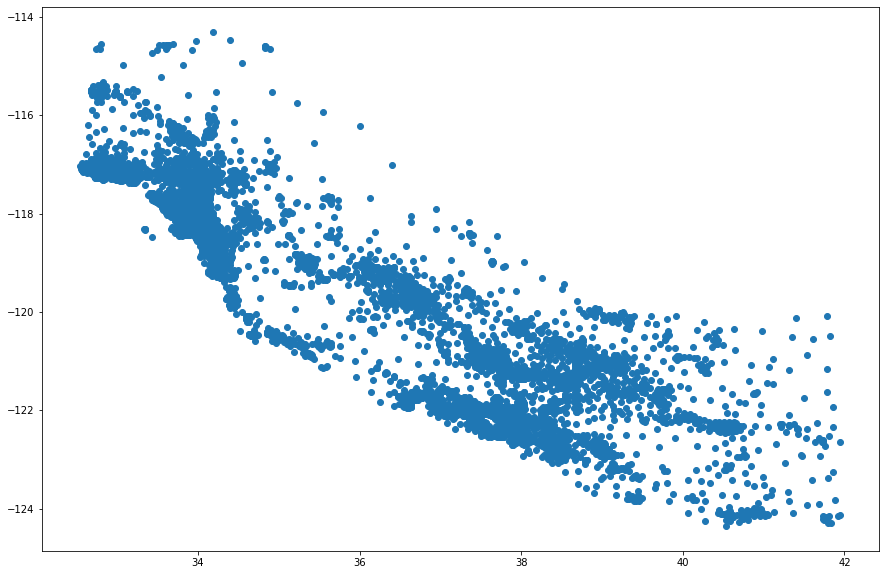

In [16]:
plt.figure(figsize=(15,10))
plt.scatter(housing_eda["latitude"], y=housing_eda["longitude"])
plt.show()

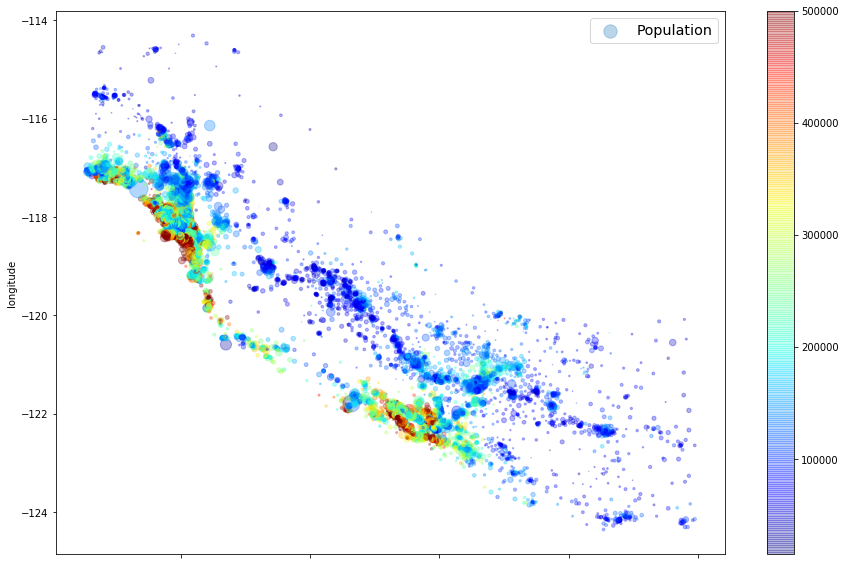

In [359]:
# Visualizing locations vs. housing prices as well as population
housing_eda.plot(kind="scatter", x="latitude", y="longitude", alpha=0.3, figsize=(15,10),
            c=housing_eda["median_house_value"], cmap=plt.get_cmap("jet"),
           label="Population", s=housing_eda["population"]/100, colorbar=True)
plt.legend(fontsize="x-large")
plt.show()

In [33]:
# Correlation matrix
corr_matrix = housing.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1,-0.924664,-0.108197,0.044568,0.069608,0.0997732,0.0553101,-0.0151759,-0.0459666
latitude,-0.924664,1,0.0111727,-0.0360996,-0.0669828,-0.108785,-0.0710354,-0.0798091,-0.14416
housing_median_age,-0.108197,0.0111727,1,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.0360996,-0.361262,1,0.93038,0.857126,0.918484,0.19805,0.134153
total_bedrooms,0.069608,-0.0669828,-0.320451,0.93038,1,0.877747,0.979728,-0.00772285,0.0496862
population,0.0997732,-0.108785,-0.296244,0.857126,0.877747,1,0.907222,0.00483435,-0.0246497
households,0.0553101,-0.0710354,-0.302916,0.918484,0.979728,0.907222,1,0.0130331,0.0658427
median_income,-0.0151759,-0.0798091,-0.119034,0.19805,-0.00772285,0.00483435,0.0130331,1,0.688075
median_house_value,-0.0459666,-0.14416,0.105623,0.134153,0.0496862,-0.0246497,0.0658427,0.688075,1


In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [37]:
corr_matrix["total_rooms"].sort_values(ascending=False)

total_rooms           1.000000
total_bedrooms        0.930380
households            0.918484
population            0.857126
median_income         0.198050
median_house_value    0.134153
longitude             0.044568
latitude             -0.036100
housing_median_age   -0.361262
Name: total_rooms, dtype: float64

Top 4 attributes above are highly correlated for total_rooms --> might handle this.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1348d29d0>,
      dtype=object)

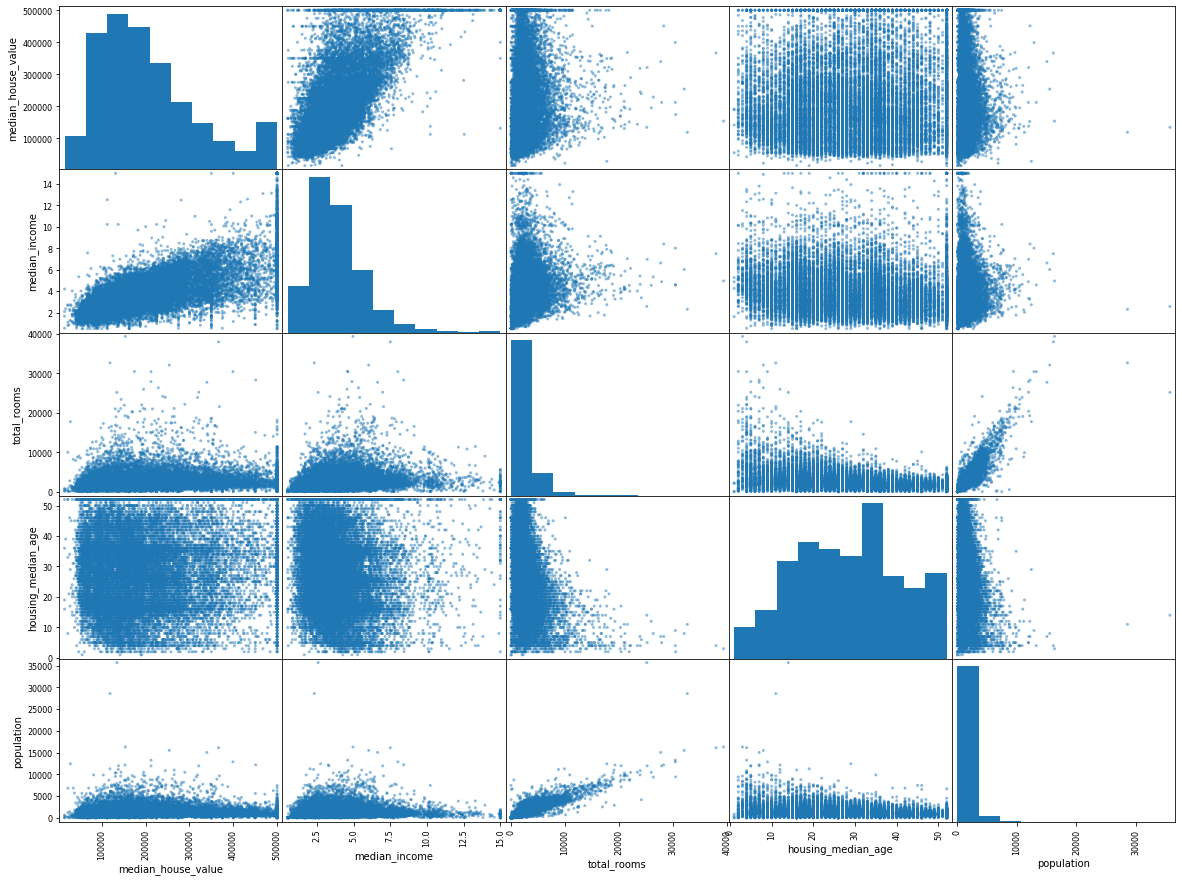

In [42]:
# Visualize chosen, attributes 
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income",
              "total_rooms", "housing_median_age", "population"]
scatter_matrix(housing_eda[attributes], figsize=(20, 15))

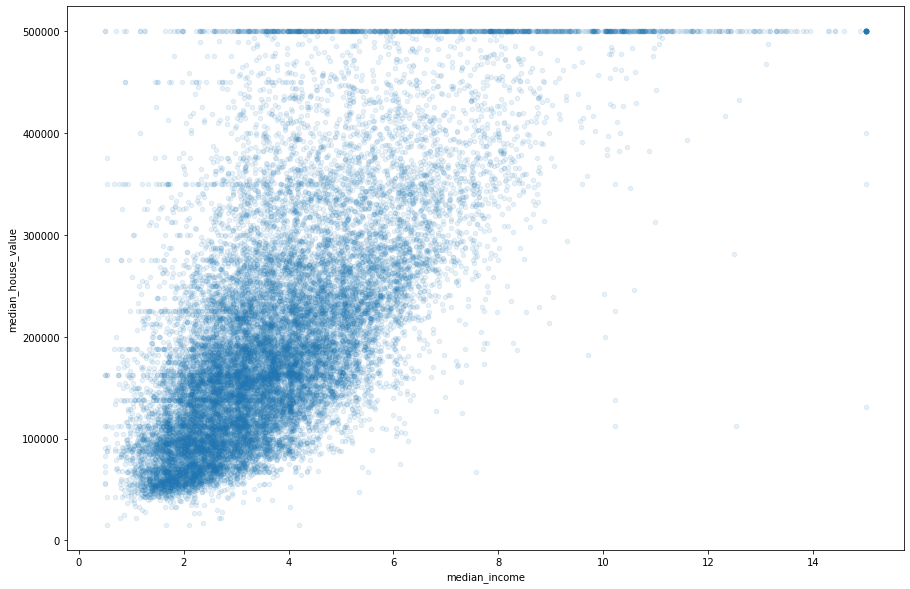

In [48]:
housing_eda.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(15,10))

We can see the capping at 50000 in the scatter plot.

## Data Pre-Processing

### Numerical Pre-Processing

In [72]:
X_train_pp = X_train.copy()
X_train_pp.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
249,-122.22,37.78,44.0,1678.0,514.0,1700.0,495.0,2.0801,NEAR BAY,2
2355,-119.68,36.77,21.0,1260.0,182.0,583.0,205.0,6.0132,INLAND,4
11234,-117.96,33.80,30.0,729.0,131.0,488.0,139.0,4.7667,<1H OCEAN,3
14455,-117.28,32.83,34.0,2392.0,653.0,933.0,619.0,3.7306,NEAR OCEAN,2
19071,-122.53,38.32,22.0,3577.0,NaN,1371.0,501.0,5.7950,<1H OCEAN,3


In [73]:
X_train_pp = X_train_pp.drop("income_cat", axis=1)

In [74]:
X_train_pp.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
249,-122.22,37.78,44.0,1678.0,514.0,1700.0,495.0,2.0801,NEAR BAY
2355,-119.68,36.77,21.0,1260.0,182.0,583.0,205.0,6.0132,INLAND
11234,-117.96,33.80,30.0,729.0,131.0,488.0,139.0,4.7667,<1H OCEAN
14455,-117.28,32.83,34.0,2392.0,653.0,933.0,619.0,3.7306,NEAR OCEAN
19071,-122.53,38.32,22.0,3577.0,NaN,1371.0,501.0,5.7950,<1H OCEAN


In [170]:
# Combining attributes (ratios) to gain additional information from the data to see which ones to choose for
# my numerical preprocessing pipeline.
X_train_pp["bedrooms_per_room"] = X_train_pp["total_bedrooms"] / X_train_pp["total_rooms"]
X_train_pp["rooms_per_household"] = X_train_pp["total_rooms"] / X_train_pp["households"]
X_train_pp["population_per_household"] = X_train_pp["population"] / X_train_pp["households"]
X_train_pp["household_per_neighbourhood"] = X_train_pp["households"] / X_train_pp["population"]

In [173]:
X_train_pp

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bedrooms_per_room,rooms_per_household,population_per_household,household_per_neighbourhood
249,-122.22,37.78,44.0,1678.0,514.0,1700.0,495.0,2.0801,NEAR BAY,0.306317,3.389899,3.434343,0.291176
2355,-119.68,36.77,21.0,1260.0,182.0,583.0,205.0,6.0132,INLAND,0.144444,6.146341,2.843902,0.351630
11234,-117.96,33.80,30.0,729.0,131.0,488.0,139.0,4.7667,<1H OCEAN,0.179698,5.244604,3.510791,0.284836
14455,-117.28,32.83,34.0,2392.0,653.0,933.0,619.0,3.7306,NEAR OCEAN,0.272993,3.864297,1.507270,0.663451
19071,-122.53,38.32,22.0,3577.0,NaN,1371.0,501.0,5.7950,<1H OCEAN,NaN,7.139721,2.736527,0.365427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20474,-118.75,34.26,26.0,1767.0,265.0,1040.0,250.0,5.4787,<1H OCEAN,0.149972,7.068000,4.160000,0.240385
13975,-116.76,34.23,10.0,4374.0,989.0,1020.0,376.0,2.6071,INLAND,0.226109,11.632979,2.712766,0.368627
8907,-118.47,34.03,29.0,3287.0,882.0,1523.0,823.0,3.7381,<1H OCEAN,0.268330,3.993925,1.850547,0.540381
16805,-122.41,37.66,32.0,1385.0,356.0,1096.0,353.0,4.4750,NEAR OCEAN,0.257040,3.923513,3.104816,0.322080


I will go with bedrooms_per_room, rooms_per_household and household_per_neighbourhood.

In [77]:
# Correlation matrix incl. combined attributes
corr_matrix_train = X_train_pp.corr()
corr_matrix_train.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_room,rooms_per_household,population_per_household
longitude,1,-0.924331,-0.104581,0.0425741,0.0673573,0.0990307,0.0538734,-0.0155149,0.0878849,-0.0254014,0.000556346
latitude,-0.924331,1,0.00735965,-0.0338603,-0.0647282,-0.109447,-0.0701954,-0.07977,-0.109668,0.105674,0.00378791
housing_median_age,-0.104581,0.00735965,1,-0.362443,-0.319303,-0.301935,-0.301376,-0.115209,0.133645,-0.145618,0.0134103
total_rooms,0.0425741,-0.0338603,-0.362443,1,0.92798,0.864818,0.916862,0.198067,-0.1861,0.125472,-0.0243122
total_bedrooms,0.0673573,-0.0647282,-0.319303,0.92798,1,0.885482,0.979362,-0.0107695,0.0907481,-0.00121676,-0.027901
population,0.0990307,-0.109447,-0.301935,0.864818,0.885482,1,0.915278,0.00418105,0.0401973,-0.0780687,0.07185
households,0.0538734,-0.0701954,-0.301376,0.916862,0.979362,0.915278,1,0.0106932,0.0705722,-0.0844225,-0.0268312
median_income,-0.0155149,-0.07977,-0.115209,0.198067,-0.0107695,0.00418105,0.0106932,1,-0.616289,0.304761,0.0212192
bedrooms_per_room,0.0878849,-0.109668,0.133645,-0.1861,0.0907481,0.0401973,0.0705722,-0.616289,1,-0.393214,0.00409521
rooms_per_household,-0.0254014,0.105674,-0.145618,0.125472,-0.00121676,-0.0780687,-0.0844225,0.304761,-0.393214,1,-0.00584837


In [161]:
# Transformer to combine attributes
from sklearn.base import BaseEstimator, TransformerMixin

# Column indeces
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # No fitting for this transformer
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        household_per_neighbourhood =  X[:, households_ix] / X[:, population_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, household_per_neighbourhood,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, household_per_neighbourhood]

In [271]:
# Transformer for log10 distribution --> Not in use due to SVM does not assume normal distribution
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class log_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        pass
    def fit(self, X, y=None):
        return self # No fitting for this transformer
    def transform(self, X):
        return np.c_[X[:,:2], np.log10(X[:, 2:])]

### Creating pipeline for numerical pre-processing

In [361]:
num_attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [362]:
len(num_attributes)

8

In [288]:
# Numerical pre-processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attrb_adder", CombinedAttributesAdder()),
    ("scaler", StandardScaler())
])

In [364]:
housing_num_tr = num_pipeline.fit_transform(X_train[num_attributes])

In [365]:
housing_num_tr[1,:]

array([-0.05421396,  0.53188408, -0.60140225, -0.63985308, -0.85461795,
       -0.77123201, -0.77589481,  1.12835195,  0.26759291, -0.13746341,
       -1.04265477])

In [366]:
len(housing_num_tr[1,:])

11

### Categorical Pre-Processing

In [368]:
cat_attributes

['ocean_proximity']

In [91]:
X_train["ocean_proximity"].value_counts()

<1H OCEAN     7286
INLAND        5248
NEAR OCEAN    2122
NEAR BAY      1851
ISLAND           5
Name: ocean_proximity, dtype: int64

In [94]:
# Dropping first value for one-hot encoder to have one less feature
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False, drop="first")
housing_cat_1hot = cat_encoder.fit_transform(X_train[cat_attributes])
housing_cat_1hot

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [95]:
# Preprocessing pipeline for cateogorical values
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(sparse=False, drop="first"))
])

In [96]:
# Testing cat_pipeline
cat_pipeline.fit_transform(X_train[cat_attributes])

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

### Combining the Pipes

In [369]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
249,-122.22,37.78,44.0,1678.0,514.0,1700.0,495.0,2.0801,NEAR BAY,2
2355,-119.68,36.77,21.0,1260.0,182.0,583.0,205.0,6.0132,INLAND,4
11234,-117.96,33.80,30.0,729.0,131.0,488.0,139.0,4.7667,<1H OCEAN,3
14455,-117.28,32.83,34.0,2392.0,653.0,933.0,619.0,3.7306,NEAR OCEAN,2
19071,-122.53,38.32,22.0,3577.0,NaN,1371.0,501.0,5.7950,<1H OCEAN,3


In [370]:
X_train.drop("income_cat", axis=1, inplace=True)

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [108]:
num_attributes = [feature for feature in X_train.columns if housing[feature].dtype != "O"]
cat_attributes = [feature for feature in X_train.columns if housing[feature].dtype == "O"]
print("Num attributes:", num_attributes)
print("Cat attributes:", cat_attributes)

Num attributes: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Cat attributes: ['ocean_proximity']


In [371]:
# Combining both numerical and categorical preprocessing
from sklearn.compose import ColumnTransformer

preprocessing_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes)
])

In [372]:
# Preprocessing X_train to test models
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

In [373]:
X_train_preprocessed.shape

(16512, 16)

## Modelling

Testing SVR models to get a feeling for how they perform

In [125]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

In [306]:
# Testing SVC with Linear kernel
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

svr = SVR(kernel="linear")
scores = cross_val_score(svr, X_train_preprocessed, y_train, cv=5,
                        scoring="neg_mean_squared_error")
print("Neg MSE: ", scores)
svr_rmse_scores = np.sqrt(-scores)
display_scores(svr_rmse_scores)

Neg MSE:  [-1.23920930e+10 -1.24832641e+10 -1.27850627e+10 -1.26653147e+10
 -1.24333351e+10]
Scores:  [111319.77811212 111728.52839382 113071.05134605 112540.28015542
 111504.8659015 ]
Mean:  112032.90078178339
Std:  665.6121618819925


In [307]:
# Testing SVC with RBF kernel
svr = SVR(kernel="rbf")
scores = cross_val_score(svr, X_train_preprocessed, y_train, cv=5,
                        scoring="neg_mean_squared_error")
print("Neg MSE: ", scores)
svr_rmse_scores_rbf = np.sqrt(-scores)
display_scores(svr_rmse_scores_rbf)

Neg MSE:  [-1.37686243e+10 -1.39117597e+10 -1.42404490e+10 -1.40943696e+10
 -1.38283617e+10]
Scores:  [117339.78138343 117948.12305525 119333.35242583 118719.71024147
 117594.05479451]
Mean:  118187.00438009776
Std:  738.1503479914132


In [308]:
# Testing normal linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train_preprocessed, y_train, cv=5,
                        scoring="neg_mean_squared_error")
print("Neg MSE: ", scores)
svr_rmse_scores_rbf = np.sqrt(-scores)
display_scores(svr_rmse_scores_rbf)

Neg MSE:  [-4.66303218e+09 -4.50997794e+09 -4.56747953e+09 -4.75091073e+09
 -4.72426560e+09]
Scores:  [68286.39823171 67156.36931947 67583.13049732 68926.85059831
 68733.29324287]
Mean:  68137.20837793521
Std:  673.8185469790476


In [309]:
# Quick function to test different optimizations below
def test_regression(X, y, cv_val=5):
    
    # Linear SVR
    print("SVR with Linear Kernel")
    svr = SVR(kernel="linear")
    scores = cross_val_score(svr, X, y, cv=cv_val,
                            scoring="neg_mean_squared_error")
    svr_rmse_scores = np.sqrt(-scores)
    display_scores(svr_rmse_scores)
    
    # RBF SVR
    print("SVR with RBF Kernel")
    svr = SVR(kernel="rbf")
    scores = cross_val_score(svr, X, y, cv=cv_val,
                            scoring="neg_mean_squared_error")
    svr_rmse_scores_rbf = np.sqrt(-scores)
    display_scores(svr_rmse_scores_rbf)
    
    #Linear regression
    print("Standard Linear Regression")
    lin_reg = LinearRegression()
    scores = cross_val_score(lin_reg, X, y, cv=cv_val,
                            scoring="neg_mean_squared_error")
    lin_rmse_scores = np.sqrt(-scores)
    display_scores(lin_rmse_scores)

### Testing to remove the truncated/capped values

In [290]:
truncatation_values

{'housing_median_age': 52.0, 'median_house_value': 500001.0}

In [294]:
no_trunc_housing = housing.copy()

In [296]:
len(no_trunc_housing)

20640

In [295]:
no_trunc_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,1


In [298]:
# Remove truncated values for 'housing_median_age'
no_trunc_housing = no_trunc_housing[no_trunc_housing["housing_median_age"] 
                                    < truncatation_values["housing_median_age"]]

In [299]:
# Remove truncated values for 'median_house_value'
no_trunc_housing = no_trunc_housing[no_trunc_housing["median_house_value"] 
                                    < truncatation_values["median_house_value"]]

In [300]:
len(no_trunc_housing)

18572

The dataset is smaller but this will very likely improve model generalization.

In [301]:
no_trunc_housing["income_cat"] = pd.cut(no_trunc_housing["median_income"],
                               bins=[0, 2, 4, 6, 8, np.inf],
                               labels=[1, 2, 3, 4, 5]                             
                              )

X_no_trunc = no_trunc_housing.copy().drop("median_house_value", axis=1)
y_no_trunc = no_trunc_housing.copy()["median_house_value"]

X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(X_no_trunc, y_no_trunc, test_size=0.2, 
                                                    random_state=42, stratify=no_trunc_housing["income_cat"])

In [310]:
X_train_nt_processed = preprocessing_pipeline.fit_transform(X_train_nt)
test_regression(X_train_nt_processed, y_train_nt)

SVR with Linear Kernel
Scores:  [91379.91682307 91654.78681696 93547.85446001 93206.32928791
 91871.99197017]
Mean:  92332.17587162409
Std:  874.006988021776
SVR with RBF Kernel
Scores:  [96621.53172096 96979.3333164  99104.63729356 98702.23436589
 97178.85554999]
Mean:  97717.3184493571
Std:  992.9779295345801
Standard Linear Regression
Scores:  [59953.61601792 57924.6083991  58315.79952142 59417.20256612
 58586.88323343]
Mean:  58839.62194759892
Std:  741.6331634105604


Significant improvement to the model.

### Combining categorical values

In [312]:
no_trunc_housing["ocean_proximity"].value_counts()

<1H OCEAN     8331
INLAND        6344
NEAR OCEAN    2328
NEAR BAY      1567
ISLAND           2
Name: ocean_proximity, dtype: int64

Only 2 Island values, combining them with Near Bay due to the similarity.

In [314]:
X_train[cat_attributes]

,ocean_proximity
249,NEAR BAY
2355,INLAND
11234,<1H OCEAN
14455,NEAR OCEAN
19071,<1H OCEAN
...,...
20474,<1H OCEAN
13975,INLAND
8907,<1H OCEAN
16805,NEAR OCEAN


In [336]:
# Transformer to combine cat features.
from sklearn.base import BaseEstimator, TransformerMixin

class combine_cat(BaseEstimator, TransformerMixin):
    def __init__(self, combine_value="ISLAND", combine_with="NEAR BAY"):
        self.combine_value = combine_value
        self.combine_with = combine_with
    def fit(self, X, y=None):
        return self # No fitting for this transformer
    def transform(self, X):
        return X.replace([self.combine_value],self.combine_with)

In [337]:
cat_pipeline_new = Pipeline([
    ("combine_features", combine_cat()),
    ("onehot", OneHotEncoder(sparse=False, drop="first"))
])

In [338]:
cat_pipeline_new.fit_transform(X_train[cat_attributes])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [339]:
from sklearn.compose import ColumnTransformer

preprocessing_pipeline_new = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline_new, cat_attributes)
])

In [342]:
X_train_preprocessed_new = preprocessing_pipeline_new.fit_transform(X_train_nt)

In [343]:
test_regression(X_train_preprocessed_new, y_train_nt)

SVR with Linear Kernel
Scores:  [91021.76754618 91349.52754339 93173.09513896 92817.110133
 91517.16954198]
Mean:  91975.73398070308
Std:  854.8748888285572
SVR with RBF Kernel
Scores:  [96613.64212696 96983.36251255 99093.22247213 98703.29046784
 97150.89545672]
Mean:  97708.88260724107
Std:  994.235850523658
Standard Linear Regression
Scores:  [56645.98829319 56536.29368571 57139.73984454 57459.61381855
 56923.20718616]
Mean:  56940.968565630494
Std:  334.542525209943


Minor improvements to the SVR models.

## Hyperparamater tuning for best SVR model

Finding the optimal parameters for the findal SVR model.

In [344]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_preprocessed_new, y_train_nt)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] C=1.0, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=1.0, kernel=linear, total=   4.7s
[CV] C=1.0, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ............................. C=1.0, kernel=linear, total=   3.8s
[CV] C=1.0, kernel=linear ............................................
[CV] ............................. C=1.0, kernel=linear, total=   5.2s
[CV] C=3.0, kernel=linear ............................................
[CV] ............................. C=3.0, kernel=linear, total=   3.4s
[CV] C=3.0, kernel=linear ............................................
[CV] ............................. C=3.0, kernel=linear, total=   3.4s
[CV] C=3.0, kernel=linear ............................................
[CV] ............................. C=3.0, kernel=linear, total=   3.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.6s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   3.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] .

[CV] ................... C=10.0, gamma=0.01, kernel=rbf, total=   6.5s
[CV] C=10.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=10.0, gamma=0.03, kernel=rbf, total=   7.5s
[CV] C=10.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=10.0, gamma=0.03, kernel=rbf, total=   7.0s
[CV] C=10.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=10.0, gamma=0.03, kernel=rbf, total=   6.8s
[CV] C=10.0, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.1, kernel=rbf, total=   6.1s
[CV] C=10.0, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.1, kernel=rbf, total=   6.3s
[CV] C=10.0, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.1, kernel=rbf, total=   7.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .

[CV] ................... C=300.0, gamma=0.1, kernel=rbf, total=   6.1s
[CV] C=300.0, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.1, kernel=rbf, total=   5.9s
[CV] C=300.0, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.1, kernel=rbf, total=   5.8s
[CV] C=300.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   5.8s
[CV] C=300.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   7.0s
[CV] C=300.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   8.1s
[CV] C=300.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=1.0, kernel=rbf, total=   5.6s
[CV] C=300.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed: 15.1min finished


GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [347]:
grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}

In [348]:
from sklearn.metrics import mean_squared_error
X_train_pred = grid_search.best_estimator_.predict(X_train_preprocessed_new)
mse = mean_squared_error(y_train_nt, X_train_pred)
np.sqrt(mse)

57701.80839554984

**Much better score than before, the hyperparamater tuning did improve the models MSE on the training set. Now, lets create the E2E full pipeline and test the model on the test set.** 

In [349]:
final_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline_new),
    ("SVR_linear", SVR(**grid_search.best_params_))
])

In [351]:
final_pipeline.fit(X_train_nt, y_train_nt)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attrb_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                        

In [352]:
y_test_pred = final_pipeline.predict(X_test_nt)

In [353]:
mse = mean_squared_error(y_test_nt, y_test_pred)
np.sqrt(mse)

56436.83893782391

**Even better score than the training set, nice. The model generalized well.**

In [354]:
# Save final model incl preprocessing.
import joblib

final_model = final_pipeline
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

---------------

# Notes and drafts

Can be done to further improve model:
- Feature selection
- Combine longitude / latitude into "zones"
- Trying out many different models